# COGS 108 - Final Project 

# Overview:

There are many factors that can influence how high of a rating a movie gets, but we were curious about what group of actors would statistically give the highest rating. By averaging out the scores of an actor's previous movies, we can quantify the impact of their presence on any movie and see how they would fit in with other actors for future movies. With the power of data science on our side, we were able to objectively analyze actors accurately and discover correlations between actor impacts and their movie ratings.

# Research Question:

Much of our perception of an actor’s ability is derived from the opinions of critics and qualitative evidence from the people we know, but what if there was an actual way to measure an actor’s impact on a movie directly? Our group’s project hopes to quantify the effect an actor’s presence in a movie has on the movie’s rating through insightful visualization of data. Ultimately, our project will answer the question: by quantifying individual actors’ impacts on movies, in other words, giving actors their own ‘IMDb score’, can we find a relationship between these “actor ratings” and IMDb scores and create a “dream cast” that maximizes the IMDb movie score?

# Hypothesis:


The hypothesis we drew wasn't really a general hypothesis, but more of an actor-specific collection of smaller hypotheses. For example, what was Harrison Ford's impact on the movies he was in? From there, we started to look for general trends among actors' IMDb ratings from their entire collection of movies against the IMDb ratings for a specific movie they were in. We suspect that there is some correlation between actors' ratings, but deny that actors' ratings are ultimately predicative of a movie's IMDb score because there are many factors such as director, budget, genre, etc. Regardless, we should still be able to generate a "dream cast" composed of actors/actresses that we think will generate the highest IMDb movie score.

## Background and Prior Work:

We wanted to explore what effect different actors/actresses might have on movie ratings and predict who would yield the highest ratings based on our chosen dataset.

One statistic that came to mind was that Will Smith had never appeared in a movie that had a Rotten Tomatoes rating of over 70%. While generally perceived as an acclaimed actor, his movie ratings proved otherwise. We wanted to catch anomalies like these in our dataset by taking their IMDb movie ratings into account. Ultimately, the cast of a movie only plays a part in how the movie will finally be received. Movies like Suicide Squad had star-studded casts but ultimately had very poor reception. One of our goals was to find out how to generate casts and find actors that would have the most actual impact on a movie's rating.

We started to look through the IMDb lists that were posted, but none actually showed the actual ratings of the movies they were in. Instead, they mostly relied on critical opinions, usually at the discretion of the just author of the list. With our methodology, we take reviews generated from hundreds of users and critics alike to generate actor ratings more closely aligned to the actual public opinion.

References:

1) https://www.unilad.co.uk/film-and-tv/will-smith-movies-havent-rated-above-70-on-rotten-tomatoes-since-1998/

2) https://www.imdb.com/list/ls050274118/

# Dataset(s):

For our project, we used the IMDB 5000 Movie Dataset from Kaggle.com (linked below). This dataset contains general information for around 5000 popular movies, most being English, U.S. movies. Each row has 28 columns, but for the purpose of our project, we used the following fields: 'movie_title', 'imdb_score', 'actor_1_name', 'actor_2_name', 'actor_3_name'.
- Dataset Name: IMDB 5000 Movie Dataset
- Link to the dataset: https://www.kaggle.com/carolzhangdc/imdb-5000-movie-dataset
- Number of observations: 5043

# Setup:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

# Data Cleaning:

To begin our analysis, we first needed to clean the "IMDB 5000 Movie Dataset" because the data had extraneous information that we did not need for our project such as the director's name and the movie's facebook likes. Since we are interested in finding a relationship between movies and actors' impact on movies, movies without actors were also excluded.

After cleaning the data, we were left with the most desired information for our purposes: movie title, IMDb score, actor 1 name of a movie, actor 2 name of a movie, actor 3 name of a movie. These data sets were then used for the rest of the data analysis on this report.  

In [2]:
# Load in the movies dataset with the desired columns
cols = ['movie_title', 'imdb_score', 'actor_1_name', 'actor_2_name', 'actor_3_name']
movie_df = pd.read_csv('movie_metadata.csv', usecols=cols)
print("Number of titles in dataset: {}".format(movie_df.shape[0]))

# Drop movies that have no actors
movie_df.dropna(subset=['actor_1_name', 'actor_2_name', 'actor_3_name'], how='all', inplace=True)
print("Number of titles after dropping those missing cast data: {}".format(movie_df.shape[0]))

Number of titles in dataset: 5043
Number of titles after dropping those missing cast data: 5036


In [3]:
# Undistinguish actor1, actor2, and actor3 columns with new df with one row per actor

movie_actor_1_df = movie_df[['movie_title', 'imdb_score', 'actor_1_name']]
movie_actor_1_df.columns = ['movie_title', 'imdb_score', 'actor']

movie_actor_2_df = movie_df[['movie_title', 'imdb_score', 'actor_2_name']]
movie_actor_2_df.columns = ['movie_title', 'imdb_score', 'actor']

movie_actor_3_df = movie_df[['movie_title', 'imdb_score', 'actor_3_name']]
movie_actor_3_df.columns = ['movie_title', 'imdb_score', 'actor']

movie_actor_df = pd.concat([movie_actor_1_df, movie_actor_2_df, movie_actor_3_df])

# drop the null actor rows (not all movies had an actor2 and/or actor3)
movie_actor_df.dropna(subset=['actor'], inplace=True)

To be able to quantify individual actor's impact on a movie, we took their average IMDb scores (average of all movies that they have been in) and gave each of them a single "IMDb score." We also excluded any actors that have appeared in less than 5 movies to standardize the list of actors to those who have consistently appeared in U.S. movies. 

In [4]:
# Create df that maintains actors and their average imdb score
actor_df = movie_actor_df.groupby('actor').agg({'movie_title': 'count', 'imdb_score': 'sum'}).reset_index()
actor_df.rename(columns={'movie_title': 'num_movies', 'imdb_score': 'avg_imdb_score'}, inplace=True)
actor_df['avg_imdb_score'] = actor_df['avg_imdb_score'] / actor_df['num_movies']
print("Number of actors appearing throughout movies: {}".format(actor_df.shape[0]))
    
# Remove actors that have not appeared in enough movies
min_movies = 5
actor_df = actor_df[actor_df['num_movies'] >= min_movies]
print("Number of actors appearing in at least {} movies: {}".format(min_movies, actor_df.shape[0]))

Number of actors appearing throughout movies: 6255
Number of actors appearing in at least 5 movies: 744


We lastly calculated the average IMBd score of each movie's cast to be able to quantify the impact of actors as a whole cast on their movies. 

In [5]:
# Copy over actor average imdb score to movie_actor_df
actor_df.set_index('actor', inplace=True)
movie_actor_df.set_index('actor', inplace=True)
movie_actor_df['avg_imdb_score'] = actor_df['avg_imdb_score']
movie_actor_df.reset_index(inplace=True)

# drop the rows for actors we removed (those that didn't appear in enough movies)
movie_actor_df.dropna(subset=['avg_imdb_score'], inplace=True)

# Calculate each movie's cast's average imdb score
movie_actor_agg_df = movie_actor_df.groupby(['movie_title', 'imdb_score']).mean().reset_index()
movie_actor_agg_df.rename(columns={'avg_imdb_score': 'cast_avg_imdb_score'}, inplace=True)

# Data Analysis & Results:

### First, we displayed the average IMDb score for some of our favorite actors/actresses.


To get a better understanding of IMDb scores of actors and actresses, we looked at 11 famous actors and 10 famous actresses starred in mostly english U.S. movies. For each of them, we averaged the IMDb scores of the movies that they have appeared in. 

In [6]:
# Some actors that we are interested in
famous_actor = ['Harrison Ford', 'Leonardo DiCaprio', 'Brad Pitt', 'Will Smith', 'Tom Hanks', 'Matt Damon', 
                 'Robert De Niro', 'Morgan Freeman', 'Christian Bale', 'Johnny Depp', 'Adam Sandler']

# Some actresses that we are interested in
famous_actress = ['Jennifer Lawrence', 'Emma Watson', 'Julia Roberts', 'Natalie Portman', 'Anne Hathaway',
                  'Scarlett Johansson', 'Emma Stone', 'Meryl Streep', 'Mila Kunis', 'Kristen Stewart']

# Get the average imdb score for each actor of interest
famous_actor_scores = []
for actor in famous_actor:
    try:
        score = actor_df.loc[actor, 'avg_imdb_score']
        famous_actor_scores.append(score)
    except KeyError:
        # actor not in actor_df
        famous_actor.remove(actor)
        
# Get the average imdb score for each actress of interest
famous_actress_scores = []
for actress in famous_actress:
    try:
        score = actor_df.loc[actress, 'avg_imdb_score']
        famous_actress_scores.append(score)
    except KeyError:
        # actress not in actor_df
        famous_actress.remove(actress) 

Text(0.5, 1.0, "Famous Actors' Average IMDb Score")

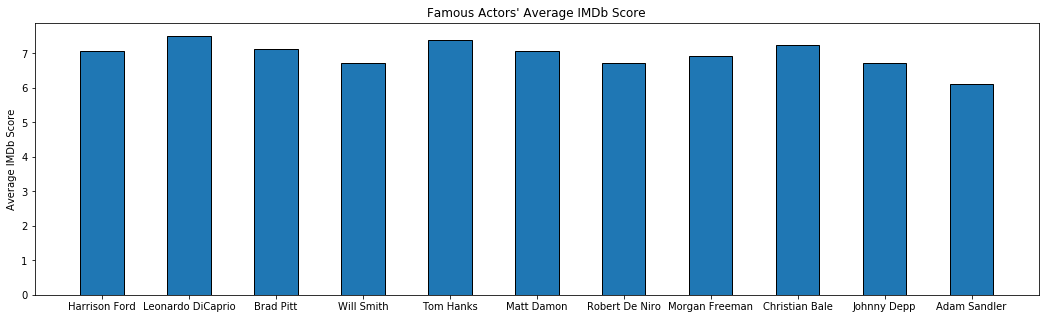

In [7]:
# plotting average scores for famous actors
plt.figure(figsize=(18, 5))
plt.bar(famous_actor, famous_actor_scores, align='center', width=0.5, edgecolor='black')
plt.ylabel('Average IMDb Score')
plt.title("Famous Actors' Average IMDb Score")

Looking at the bar graph above, all of these famous actors have similar average IMDb scores of close to 7. This gave us reason to believe that perhaps average IMDb score could be indication of a famous, successful actor (if all famous actors have around the same average score). However before making any conclusions, we took a look at the famous actresses' average IMDb scores as well. 

Text(0.5, 1.0, "Famous Actresses' Average IMDb Score")

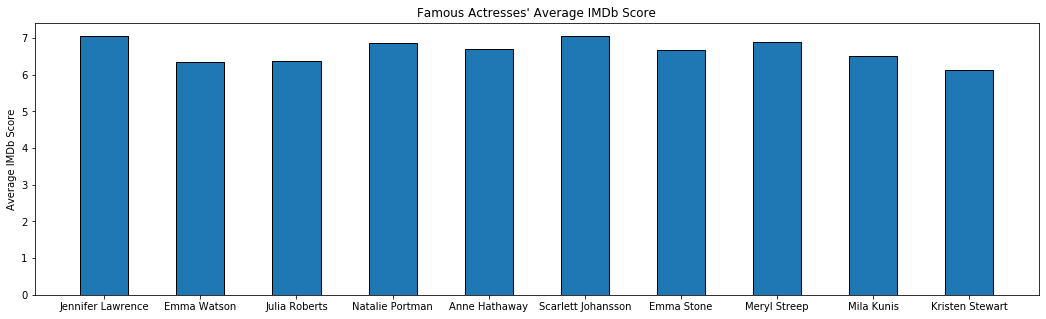

In [8]:
# plotting average scores for famous actresses
plt.figure(figsize=(18, 5))
plt.bar(famous_actress, famous_actress_scores, align='center', width=0.5, edgecolor='black')
plt.ylabel('Average IMDb Score')
plt.title("Famous Actresses' Average IMDb Score")

Similar to the "Famous Actor's Average IMDb Score" graph, all of these famous actresses have similar average IMDb score of close to 7. This again gave us reason to believe that perhaps average IMDb score could be indication of a famous, successful actress. Also, famous actors and famous actresses seem to have roughly the same average scores. From our sample of individuals, gender doesn't seem to affect the score. 

At this point, we wanted to combine all actors and actresses and see how their average IMDb scores compare to that of these selected famous actors and actresses.

### To do this, we looked at the distribution of average IMDb scores amongst all actors/actresses.

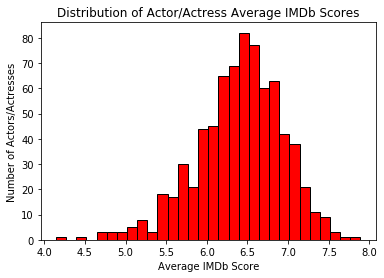

mean: 6.40
standard deviation: 0.53


In [9]:
scores = actor_df['avg_imdb_score'].to_numpy()
plt.hist(scores, color='red', edgecolor='black', bins=30)
plt.xlabel('Average IMDb Score')
plt.ylabel('Number of Actors/Actresses')
plt.title('Distribution of Actor/Actress Average IMDb Scores')
plt.show()
print("mean: {0:.2f}".format(scores.mean()))
print("standard deviation: {0:.2f}".format(scores.std()))

The distribution seemed relatively normal. From our two previous graphs, we know that the famous actors and actresses had average IMDb scores of close to 7. The mean average IMDb score for all actors and actresses was 6.4 and the standard deviation was 0.53. This meant that famous actors and actresses had averages about a standard deviation above the mean, which was lower than expected. Although we would think that most famous actors would have averages way above the mean, the averages were pretty uniform. We could interpret that an actor's fame does not necessarily equate to a high average IMDb score.

### Now, we looked at the distribution of movie IMDb scores.

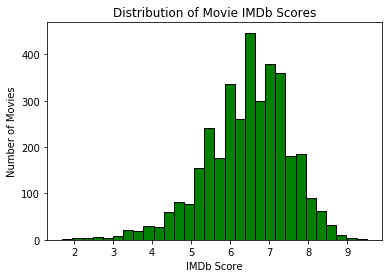

mean: 6.44
standard deviation: 1.06


In [10]:
scores = movie_actor_agg_df['imdb_score'].to_numpy()
plt.hist(scores, color='green', edgecolor='black', bins=30)
plt.xlabel('IMDb Score')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie IMDb Scores')
plt.show()
print("mean: {0:.2f}".format(scores.mean()))
print("standard deviation: {0:.2f}".format(scores.std()))

Like the distribution of actor/actress average IMDb scores, the movie IMDb score distribution seemed to be relatively normal. Interestingly, the mean movie IMDb score is very close to the mean actor/actress average IMDb score (6.44 and 6.4 respectively).

### Moving on, we looked at the distribution of movie casts' average 'actor/actress IMDb score average'

Seeing that both the actor/actress average IMDb score distribution and the movie IMDb score distribution are relatively normal and share a close mean average score, we thought it would be interesting to take a look at the movie casts' average IMDs score. This refers to the average of IMDb score averages from all the actors/actresses in the movie cast. 

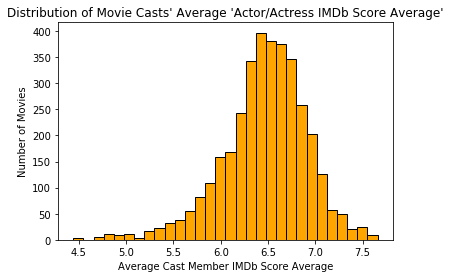

mean: 6.46
standard deviation: 0.45


In [11]:
scores = movie_actor_agg_df['cast_avg_imdb_score'].to_numpy()
plt.hist(scores, color='orange', edgecolor='black', bins=30)
plt.xlabel("Average Cast Member IMDb Score Average")
plt.ylabel("Number of Movies")
plt.title("Distribution of Movie Casts' Average 'Actor/Actress IMDb Score Average'")
plt.show()
print("mean: {0:.2f}".format(scores.mean()))
print("standard deviation: {0:.2f}".format(scores.std()))

As seen above, the distribution was once again relatively normal and had a very close mean average of 6.46 to the previous two distributions. This got us to the next two questions:

### Is there a correlation between actor/actress average IMDb scores and movie IMDb scores?

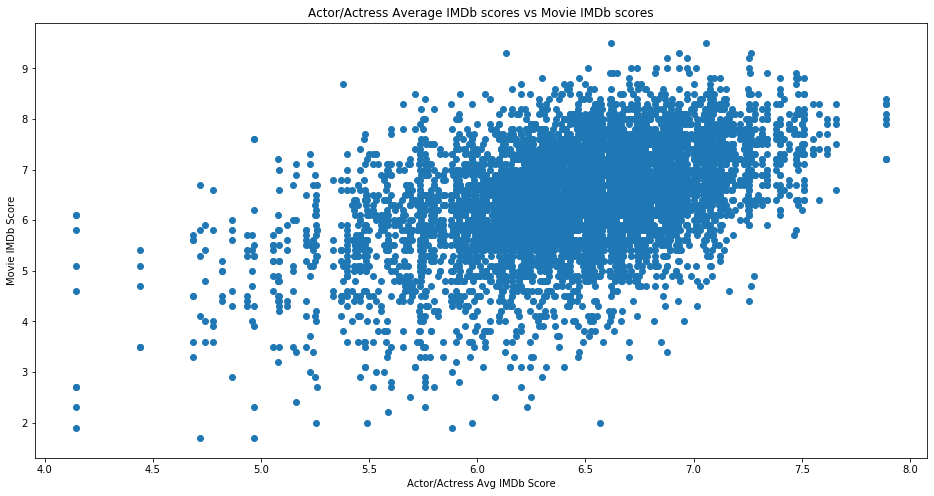

Strength of a linear relationship between actor avg IMDb score and movie IMDb score: ...
Pearson's correlation: 0.476

Strength of a possible nonlinear relationship between actor avg IMDb score and movie IMDb score: ...
Spearman's correlation: 0.451


In [12]:
# plotting actor/actress average IMDb scores vs actual movie IMDb scores
actor_avgs = movie_actor_df['avg_imdb_score'].to_numpy()
movie_scores = movie_actor_df['imdb_score'].to_numpy()

plt.figure(figsize=(16, 8))
plt.scatter(actor_avgs, movie_scores)
plt.xlabel('Actor/Actress Avg IMDb Score')
plt.ylabel('Movie IMDb Score')
plt.title('Actor/Actress Average IMDb scores vs Movie IMDb scores')
plt.show()

pearson, _ = stats.pearsonr(actor_avgs, movie_scores)
print("Strength of a linear relationship between actor avg IMDb score and movie IMDb score: ...")
print("Pearson's correlation: %.3f\n" % pearson)

spearman, _ = stats.spearmanr(actor_avgs, movie_scores)
print("Strength of a possible nonlinear relationship between actor avg IMDb score and movie IMDb score: ...")
print("Spearman's correlation: %.3f" % spearman)

### Is there a correlation between cast average IMDb scores and movie IMDb scores?

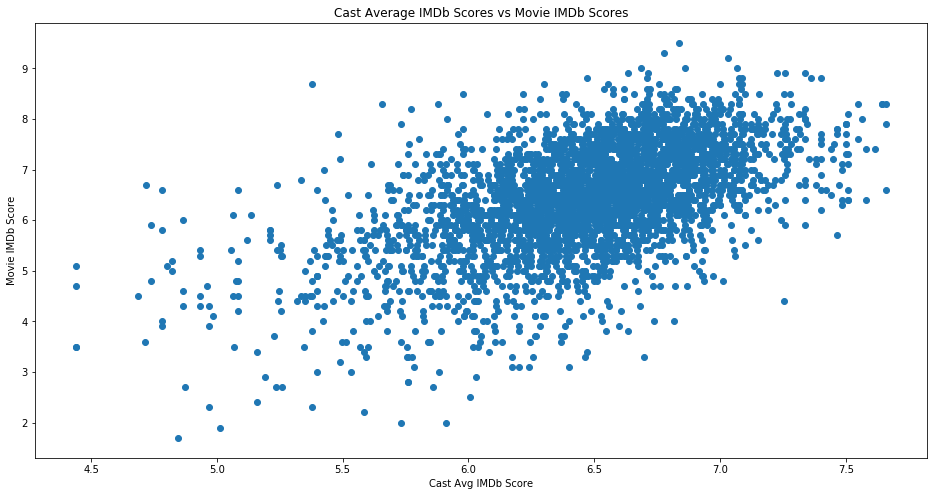

Strength of a linear relationship between cast avg IMDb score and movie IMDb score: ...
Pearson's correlation: 0.555

Strength of a possible nonlinear relationship between cast avg IMDb score and movie IMDb score: ...
Spearman's correlation: 0.542


In [13]:
# plotting cast average IMDb scores vs actual movie IMDb scores
cast_avgs = movie_actor_agg_df['cast_avg_imdb_score'].to_numpy()
movie_scores = movie_actor_agg_df['imdb_score'].to_numpy()

plt.figure(figsize=(16, 8))
plt.scatter(cast_avgs, movie_scores)
plt.xlabel('Cast Avg IMDb Score')
plt.ylabel('Movie IMDb Score')
plt.title('Cast Average IMDb Scores vs Movie IMDb Scores')
plt.show()

pearson, _ = stats.pearsonr(cast_avgs, movie_scores)
print("Strength of a linear relationship between cast avg IMDb score and movie IMDb score: ...")
print("Pearson's correlation: %.3f\n" % pearson)

spearman, _ = stats.spearmanr(cast_avgs, movie_scores)
print("Strength of a possible nonlinear relationship between cast avg IMDb score and movie IMDb score: ...")
print("Spearman's correlation: %.3f" % spearman)

Looking at both scatter plots, the cast average IMDb scores had slightly strong linear relationship to the movie IMDb scores with correlation of 0.555 than the actor/actress average IMDb scores's correlation of 0.476. However, we were able to conclude that while the actor/actress average IMDb scores and the cast average IMDb scores are positively correlated to the movie IMDb scores, neither have a strong correlation. This was expected, as we hypothesized that actors' ratings alone would not be a predicative of a movie's IMDb score.

### Top Rated and Lowest Rated Movies

Going off the previous analysis that cast average IMDb scores are slightly more correlated to movie IMDb scores, we took additional steps to further analyze the relationship between movie IMDb scores and cast average IMDb scores.

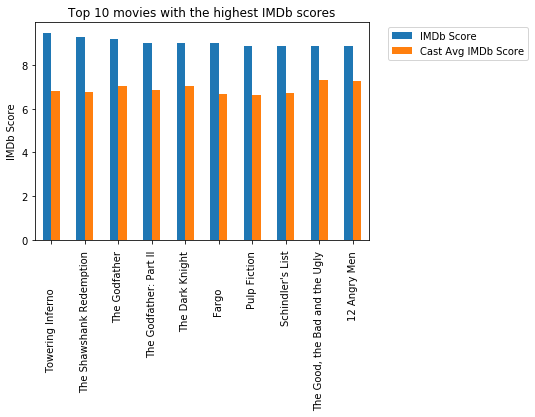

In [14]:
# Plotting the movies with the 10 highest imdb scores
movie_less_cols = movie_actor_agg_df[['movie_title', 'imdb_score', 'cast_avg_imdb_score']]
top_10_movies = movie_less_cols.sort_values('imdb_score', ascending=False)[0:10].set_index('movie_title')

top_10_movies.plot.bar()
plt.xlabel('')
plt.ylabel('IMDb Score')
plt.title("Top 10 movies with the highest IMDb scores")
plt.legend(['IMDb Score', 'Cast Avg IMDb Score'], bbox_to_anchor=(1.04,1), loc="upper left")

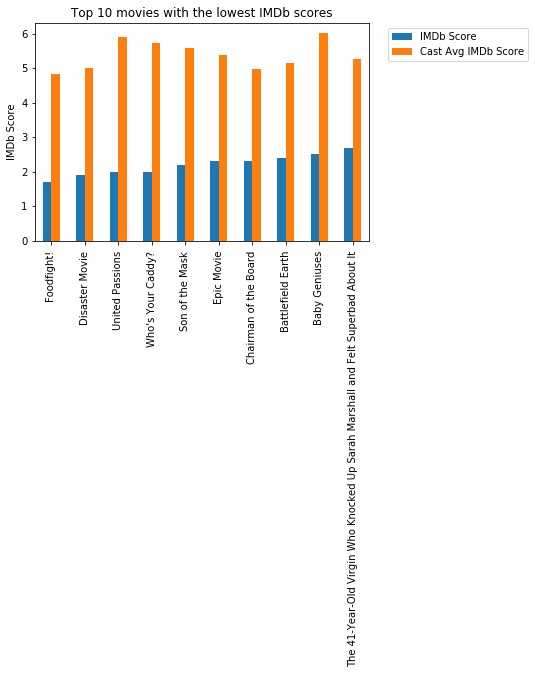

In [15]:
# Plotting the movies with the 10 lowest imdb scores
top_10_movies = movie_less_cols.sort_values('imdb_score')[0:10].set_index('movie_title')

top_10_movies.plot.bar()
plt.xlabel('')
plt.ylabel('IMDb Score')
plt.title("Top 10 movies with the lowest IMDb scores")
plt.legend(['IMDb Score', 'Cast Avg IMDb Score'], bbox_to_anchor=(1.04,1), loc="upper left")

From both of these graphs, we saw that the cast's average IMDb scores did not have a direct correlation to the movie's IMDb scores. The top rated movies had cast average IMDb scores of roughly around 7. Interestingly, the lowest rated movies consisted of cast average IMDb scores mostly between 5 and 6, only 1 to 3 standard deviations away from the overall mean average of movie cast's average IMDb scores: 6.46. 

We applied the same concept and looked at the relationship between movies and highest/lowest rated cast.

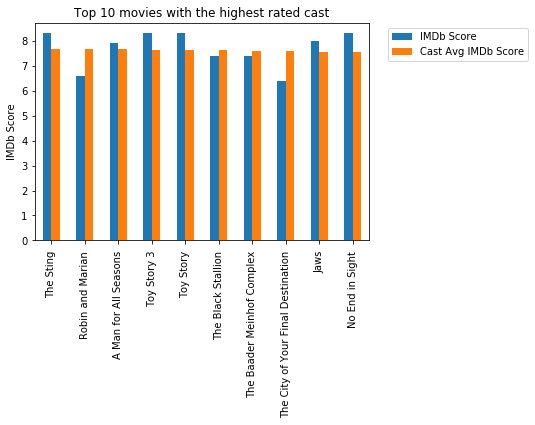

In [16]:
# Plotting the movies with the 10 highest cast avg imdb scores
top_10_movies = movie_less_cols.sort_values('cast_avg_imdb_score', ascending=False)[0:10].set_index('movie_title')

top_10_movies.plot.bar()
plt.xlabel('')
plt.ylabel('IMDb Score')
plt.title("Top 10 movies with the highest rated cast")
plt.legend(['IMDb Score', 'Cast Avg IMDb Score'], bbox_to_anchor=(1.04,1), loc="upper left")

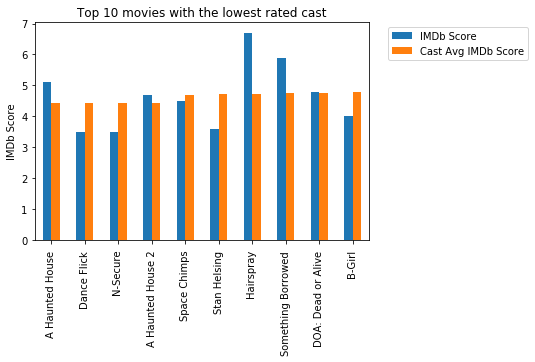

In [17]:
# Plotting the movies with the 10 lowest cast avg imdb scores
top_10_movies = movie_less_cols.sort_values('cast_avg_imdb_score')[0:10].set_index('movie_title')

top_10_movies.plot.bar()
plt.xlabel('')
plt.ylabel('IMDb Score')
plt.title("Top 10 movies with the lowest rated cast")
plt.legend(['IMDb Score', 'Cast Avg IMDb Score'], bbox_to_anchor=(1.04,1), loc="upper left")

Compared to the top/lowest rated movies' relationship with the cast average IMDb scores, the cast average IMDb scores seem to have a closer IMDb scores to their respective top 10 movies. The top 10 movies with the highest rated cast tend to have a higher movie IMDb scores as well of roughly averaging between 7 and 8. Similarly, the top 10 movies with the lowest rated cast also tend to have a lower movie IMDb scores of roughly averaging between 4 and 5. From this, we could suspect that the rating of moive cast can impact the movie's score. However, note that this relationship does not draw a direct correlation as we have to account for outliers seen in movies such as the Hairspray and Something Borrowed with more significant differences between the movie IMDb scores and cast average IMDb scores. 

### Top Rated and Lowest Rated Actors/Actresses

To address one of our initial goals to create a “dream cast” that maximizes the IMDb movie score, we looked at the 10 actors and actresses with the highest average IMDb scores and the 10 actors and actresses with the lowest average IMDb scores. 

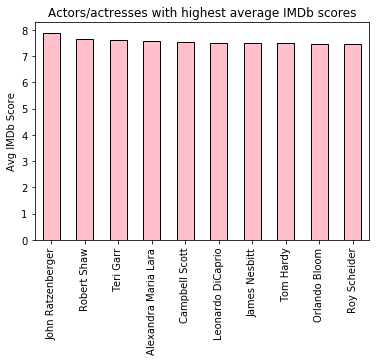

In [18]:
# Plotting the actors/actresses with the 10 highest average imdb scores
top_10_actors = actor_df.sort_values('avg_imdb_score', ascending=False)[0:10]

top_10_actors.plot.bar(y='avg_imdb_score', color='pink', edgecolor='black')
plt.xlabel('')
plt.ylabel('Avg IMDb Score')
plt.title("Actors/actresses with highest average IMDb scores")
plt.legend().remove()

John Ratzenberger, Robert Shaw and Teri Garr, who have the highest average IMDb scores, make up our "dream cast." 

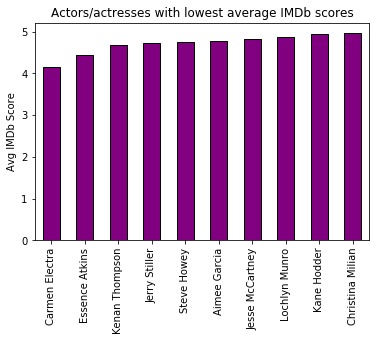

In [19]:
# Plotting the actors/actresses with the 10 lowest average imdb scores
bottom_10_actors = actor_df.sort_values('avg_imdb_score')[0:10]

bottom_10_actors.plot.bar(y='avg_imdb_score', color='purple', edgecolor='black')
plt.xlabel('')
plt.ylabel('Avg IMDb Score')
plt.title("Actors/actresses with lowest average IMDb scores")
plt.legend().remove()

### A linear model predicting Movie IMDb scores from Cast Average IMDb scores

Taking the IMDb scores of the three individuals in our dream cast, we calculated the dream cast average IMDb score and gave that as an input to the linear model. 

In [20]:
# Note y (predicting) variable comes before x (predictor) variable in sm.OLS args
linear_model = sm.OLS(movie_scores, cast_avgs).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          1.870e+05
Date:                Thu, 12 Dec 2019   Prob (F-statistic):                        0.00
Time:                        11:24:53   Log-Likelihood:                         -4646.1
No. Observations:                3562   AIC:                                      9294.
Df Residuals:                    3561   BIC:                                      9300.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9973      0.002    432.387      0.000       0.993       1.002
==============================================================================
Omnibus:                      186.116   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.581
Skew:                          -0.488   Prob(JB):                     5.23e-56
Kurtosis:                       3.872   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Predicting the IMDb score for 'dream cast' movie

Finally, using the linear model, we predicted the IMDb movie score for our dream cast. 

In [21]:
top_10_actors.reset_index(inplace=True)
cast_avg_imdb_score = top_10_actors[0:3]['avg_imdb_score'].mean()

cast = []
for i in range(3):
    actor = top_10_actors.loc[i, 'actor']
    cast.append(actor)
    print("Actor {}: {}".format(i+1, actor))
    print("Average IMDb score: {0:.2f}".format(top_10_actors.loc[i, 'avg_imdb_score']))
    print("--------")
print("Cast Average IMDb score: {0:.2f}\n".format(cast_avg_imdb_score))

predicted_imdb_score = linear_model.predict([cast_avg_imdb_score])[0].round(2)
cast_as_str = ", ".join(cast)
print("Predicting an IMDb score of {} for a movie with {}".format(predicted_imdb_score, cast_as_str))

Actor 1: John Ratzenberger
Average IMDb score: 7.89
--------
Actor 2: Robert Shaw
Average IMDb score: 7.66
--------
Actor 3: Teri Garr
Average IMDb score: 7.62
--------
Cast Average IMDb score: 7.72

Predicting an IMDb score of 7.7 for a movie with John Ratzenberger, Robert Shaw, Teri Garr


# Ethics & Privacy:

Permission to Dataset: The dataset we used is publicly available on the Kaggle website. It is maintained by Yueming.

Privacy Concerns: The dataset we our using and our examination of the dataset reveals the names of around 6,000 actors/actresses. It also contains director names. We cannot guarantee privacy since we are going to be examining specific actors and actresses who will be named. However, considering the industry our research was conducted on, our concerns are relieved by the fact that actors'/actresses' identities are already exposed in greater detail than what our dataset and examination reveals.

Potential Biases: The dataset we are using contains biases because we only examine English movies. Thus, it is possible that the ratings of these movies are majorly determined by English-speaking persons and cannot be completely accurate in reflecting every individual opinion. It is also the case that the ratings provided in the dataset do not encompass all ratings for a specific movie because it only uses IMDb ratings. There are many other online sources for movie ratings that the dataset does not take into account.

Implications: Our examination can potentially affect the reputation of the movies, actors, and actresses we are investigating because we are measuring and ranking certain actors/actresses over one another in terms of impact on movie ratings. It is possible that the information we gather can be used to determine future movie casts, and thus affect the careers of certain actors and actresses. However, considering the process by which actors/actresses acquire their roles in movies, it is unlikely that our examination would be used as the sole source of choosing movie casts or for other nefarious purposes. For our particular topic, we can assume that actors/actresses are subject to various forms of criticism that already exist despite the disclosure of our findings.

# Conclusion & Discussion:

Movies are a major part of popular culture, and there are many factors that contribute to how well a movie is received by the public. We were interested in the relationship between the actors and actresses in a certain movie and how ‘good’ of a movie it was. Since there are many ways to quantify how good a movie is, we decided to use IMDb ratings as a measure of the performance. We explored the IMBDb dataset to help answer these questions and give some insight into the influence actors and actresses have on a film. We wanted to take what we found and find a possible ‘dream cast’ that would most likely give a high IMDb rating. 

At first, we wanted to interpret some of the data and find some general understandings. One thing we wanted to see was the distribution of actors and actresses scores and of IMDb scores. Both of these were normally distributed with the highest score being about 0.5-1.0 standard deviations above the mean. This was a little surprising, because you might expect actors and actresses who are more famous to have much higher averages than those who are not as known, but that was not the case. This is possibly because there are many actors and actresses who are not well known, but are in famous movies with higher scores. Now that we found some information about the scores and distributions, we wanted to answer our question and find the correlations between the cast scores and the movie scores. We found the correlation between actors and actresses average scores and the movie score was not very strong, only about 0.47, and the correlation between a cast average’s score and the movie’s score was a little stronger, about 0.55, but still not super strong. It is understandable that the cast average would be a better predictor for movie score because the entire cast contributes to the movie. We further explore this relationship of cast and movie score by comparing the top ten highest IMDb scores for movies and those movie’s cast average. We found that while the movie scores were around 8.5, the cast averages were much lower, about 6.5, showing that the movie rating is not reflective of the cast rating. Finally, we wanted to be able to build a ‘dream cast’ that would most likely yield a high movie rating. We were able to make a linear model and used it to predict the top three actors and what the movie rating would be. We found that a movie with John Ratzenberger, Robert Shaw, and Teri Garr would predict an IMDb score of 7.7. While this score is high, it is not very high and shows that even with the top three highest scoring actors all in the same movie, the IMDb score isn’t that high. 

We’ve shown that there is a relationship between the cast in a movie and that movie’s overall rating, but the actors and actresses are not good predictors for the movie rating. There are many movies with famous, successful actors and actresses that did not become famous, successful movies. The opposite is also true; there are many successful movies that do not have any famous actors or actresses at all. Advertising, directors, genre, and many other factors contribute to how successful a movie is. We cannot say that because a movie has actors and actresses with high ratings that the movie will also have a high rating, but it doesn’t hurt to have successful people in a film. 
